<a href="https://colab.research.google.com/github/soutrik71/MInMaxBERT/blob/main/notebook/BertTextClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to test out Simple and Complex Questions using a Base Bert Model:
* Focus on Tokenization part for the data
* Focus on model pre-training in pytorch
* Application of Focal loss in handling imbalanced data
* Application of adding weights to loss function for imbalanced class
* Evaluation Framework
* More homogenous and representative data

In [1]:
!pip install transformers datasets torcheval --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torcheval.metrics import BinaryAccuracy,BinaryF1Score,BinaryPrecision,BinaryRecall,BinaryConfusionMatrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Loading from git repo

In [4]:
df1 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/classifier_data.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/maz_abiconnect_curated_question_list.csv")

In [5]:
final_df = pd.concat([df1, df2.drop(["Domain"],axis=1,errors='ignore')], ignore_index=True)

In [6]:
final_df.head()

,Question,FinalLabel
0,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,simple
1,what should beThe target average time in route (Depot to Depot),simple
2,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,simple
3,What Are Tools And Equipment Used In Truck Departure Process?,simple
4,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",simple


In [7]:
final_df.shape

(621, 2)

In [8]:
final_df["FinalLabel"] = final_df["FinalLabel"].apply(lambda x: x.upper()).map({"SIMPLE":0,"COMPLEX":1})
final_df["FinalLabel"] = final_df["FinalLabel"].astype(int)

In [9]:
final_df.head()

,Question,FinalLabel
0,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,0
1,what should beThe target average time in route (Depot to Depot),0
2,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,0
3,What Are Tools And Equipment Used In Truck Departure Process?,0
4,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",0


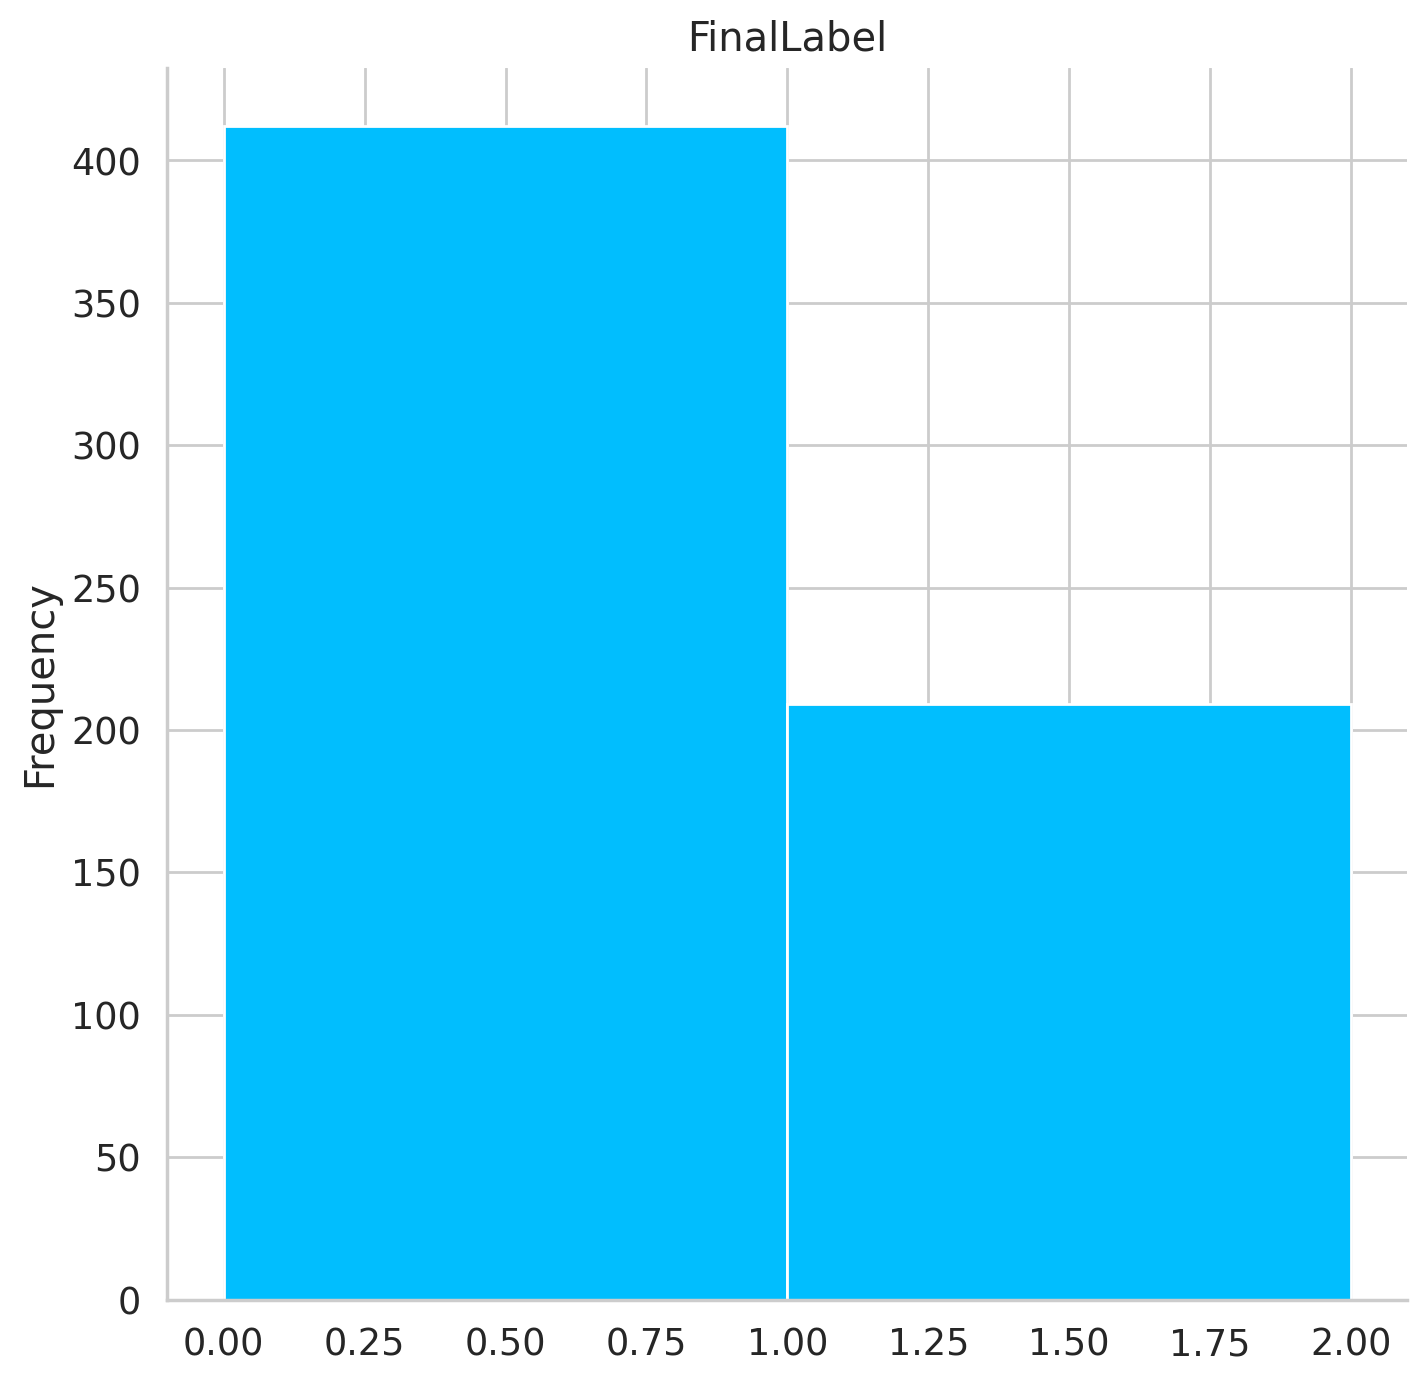

In [10]:
final_df['FinalLabel'].plot(kind='hist', bins=[0,1,2], title='FinalLabel')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
final_df.info(),"Null values",final_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Question    621 non-null    object
 1   FinalLabel  621 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


(None,
 'Null values',
 Question      0
 FinalLabel    0
 dtype: int64)

In [12]:
class_names = ['Simple', 'Complex']

In [13]:
final_df['FinalLabel'].value_counts()

0    412
1    209
Name: FinalLabel, dtype: int64

## Data Preprocessing using Bert tokenizer

In [14]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # cased means What is considered different to what ie case sensitive
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 10
learning_rate = 2e-05

In [15]:
sample_text = final_df["Question"].values[0]
print(sample_text)

What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?


We use tokenizer.encode_plus to do the follwing activities
1. Add speacila tokens like CLS[101] SEP[102] PADDING[0] and UNK[100] in the text
2. Tokenize the tokens with int encoding
3. Provide attention mask which confirms actual tokens and paddings

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True, # in case larger
  return_tensors='pt',  # Return PyTorch tensors
)

print(encoding.keys())

dict_keys(['input_ids', 'attention_mask'])


In [18]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'].shape)
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'].shape)

128
torch.Size([1, 128])
128
torch.Size([1, 128])


1 added dim is the batch size, which we have to remove while we call this within the custom torch dataset creation

## Training and evaluation dataprep

### Custom Pytorch Dataset creation

In [19]:
class QuestionClassficationDataset(Dataset):

  def __init__(self, question, targets, tokenizer, max_len):
    self.question = question
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.question)

  def __getitem__(self, item):
    review = str(self.question[item])
    if self.targets is not None:
      target = self.targets[item]

    # token encoder
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    if self.targets is not None:
      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'].squeeze(),
        'targets': torch.tensor(target, dtype=torch.float)
      }

    else:

      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'],
      }



In [20]:
sample_dataset = QuestionClassficationDataset(
  question=[final_df["Question"].values[0]],
  targets=[final_df["FinalLabel"].values[0]],
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [21]:
for ds in sample_dataset:
  print(ds.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [22]:
next(iter(sample_dataset))

{'review_text': 'What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?',
 'input_ids': tensor([  101,  1327,  1110,  1103,  6556,  1849,  1107,  3884,  1111,  1269,
          4097,  1118,  1472,  4001,  1107,  1360, 17881,  1495,  1112,  3402,
          2166,  2370,   136,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle):
  dataset = QuestionClassficationDataset(
    question=df["Question"].values,
    targets=df["FinalLabel"].values,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle
  )

In [24]:
# startified train test split
train_df , test_df = train_test_split(final_df, test_size=0.25, random_state=42, stratify=final_df["FinalLabel"])
print(train_df.shape)
print(test_df.shape)

(465, 2)
(156, 2)


In [25]:
print(train_df["FinalLabel"].value_counts()/len(train_df))
print(test_df["FinalLabel"].value_counts()/len(test_df))

0    0.664516
1    0.335484
Name: FinalLabel, dtype: float64
0    0.660256
1    0.339744
Name: FinalLabel, dtype: float64


In [26]:
# train test dataloader
train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, True)
test_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE, False)

In [48]:
# batched of 8 with 128 token size
for sample_data in train_loader:
  print(sample_data.keys())
  print(sample_data["input_ids"].shape)
  print(sample_data["attention_mask"].shape)
  print(sample_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])




In [28]:
for test_data in test_loader:
  print(test_data.keys())
  print(test_data["input_ids"].shape)
  print(test_data["attention_mask"].shape)
  print(test_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])




## Bert Classifier

In [29]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [30]:
bert_model_direct = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [32]:
bert_model_direct

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

The bert model gives you only 1 pooler with same 768 hidden units as input and output passed through a tanh activation function.

The bert_model_direct is a classfier which is build on top of the bert model with a linear classifier layer at the end

In [33]:
# application
op = bert_model(
  input_ids=sample_data['input_ids'],
  attention_mask=sample_data['attention_mask']
)

In [34]:
op['last_hidden_state'].shape

torch.Size([1, 128, 768])

In [35]:
op['pooler_output'].shape

torch.Size([1, 768])

* representation : 8 sentences with 128 tokens with each having a vector of dim 768
* Bert base has 12 sets of transformers where bert large has a set of 24
* For any downstream task we will use the pooler output

### Model Training

In [36]:
class BertSentimentClassifier(nn.Module):

  def __init__(self, n_classes, dropout = 0.1):
    super(BertSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    model_op = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_op['pooler_output']
    output = self.drop(pooled_output)
    return self.classifier(output)

In [37]:
bert_base_classifier = BertSentimentClassifier(1).to(device)
bert_base_classifier

BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [38]:
# input_ids=sample_data['input_ids'].to(device)
# attention_mask=sample_data['attention_mask'].to(device)

# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [39]:
# model_op = bert_base_classifier(input_ids, attention_mask)
# print(model_op.squeeze().shape)
# print(sample_data["targets"].shape)

In [40]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer
optimizer = AdamW(bert_base_classifier.parameters(), lr=learning_rate, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device = device)

In [41]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 scheduler,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for _,data in enumerate(pbar):

    ids = data['input_ids'].to(device)
    mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    # print(f"The target shape is {targets.shape}")

    # model output
    outputs = model(ids, mask)
    outputs = outputs.flatten()
    # print(f"The output shape is {outputs.shape}")

    # calc loss
    loss = criterion(outputs, targets)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    # gradient clipping -- prevent gradient explosion
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # improvement steps
    optimizer.step() # optimizer step -> minima
    if scheduler is not None:
      scheduler.step() # scheduler step -> lr scheduling

    # metric calc
    metric.update(outputs,targets)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [42]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for _, data in enumerate(pbar, 0):
      ids = data['input_ids'].to(device)
      mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)

      # print(f"The target shape is {targets.shape}")

      # model output
      outputs = model(ids, mask)
      outputs = outputs.flatten()

      # print(f"The output shape is {outputs.shape}")

     # calc loss
      loss = criterion(outputs, targets)
      test_loss += loss.item()

      # metric calc
      metric.update(outputs, targets)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [43]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = bert_base_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = bert_base_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )

  print(f"The learing rate is {scheduler.get_last_lr()}")


Epoch 1/10
----------


Avg Train Loss: 0.5586942469827452 Avg Train Metric: 0.4422577115691314: 100%|██████████| 59/59 [00:15<00:00,  3.74it/s]
Avg Test Loss: 0.4291114814579487 Avg Test Metric: 0.8060996443033218: 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]


The learing rate is [1.8e-05]
Epoch 2/10
----------


Avg Train Loss: 0.3445498662353572 Avg Train Metric: 0.7932408098447121: 100%|██████████| 59/59 [00:11<00:00,  4.99it/s]
Avg Test Loss: 0.3219346168451011 Avg Test Metric: 0.8292203485965729: 100%|██████████| 20/20 [00:01<00:00, 16.73it/s]


The learing rate is [1.6000000000000003e-05]
Epoch 3/10
----------


Avg Train Loss: 0.20896968682754344 Avg Train Metric: 0.9201388369172306: 100%|██████████| 59/59 [00:11<00:00,  4.97it/s]
Avg Test Loss: 0.2978958098217845 Avg Test Metric: 0.8411870807409286: 100%|██████████| 20/20 [00:01<00:00, 16.15it/s]


The learing rate is [1.4e-05]
Epoch 4/10
----------


Avg Train Loss: 0.1615473492607727 Avg Train Metric: 0.9156520043389272: 100%|██████████| 59/59 [00:12<00:00,  4.86it/s]
Avg Test Loss: 0.2917498376220465 Avg Test Metric: 0.8585846692323684: 100%|██████████| 20/20 [00:01<00:00, 15.47it/s]


The learing rate is [1.2e-05]
Epoch 5/10
----------


Avg Train Loss: 0.11681876487840535 Avg Train Metric: 0.9727467934964067: 100%|██████████| 59/59 [00:12<00:00,  4.60it/s]
Avg Test Loss: 0.29679497408214955 Avg Test Metric: 0.8268574148416519: 100%|██████████| 20/20 [00:01<00:00, 14.21it/s]


The learing rate is [1e-05]
Epoch 6/10
----------


Avg Train Loss: 0.1483812978238625 Avg Train Metric: 0.9507606433609784: 100%|██████████| 59/59 [00:12<00:00,  4.82it/s]
Avg Test Loss: 0.25296120774000885 Avg Test Metric: 0.8901589900255203: 100%|██████████| 20/20 [00:01<00:00, 16.28it/s]


The learing rate is [8.000000000000001e-06]
Epoch 7/10
----------


Avg Train Loss: 0.07450961433666742 Avg Train Metric: 0.9761645551455223: 100%|██████████| 59/59 [00:11<00:00,  4.98it/s]
Avg Test Loss: 0.3045324370265007 Avg Test Metric: 0.886482161283493: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


The learing rate is [6e-06]
Epoch 8/10
----------


Avg Train Loss: 0.08451474121755968 Avg Train Metric: 0.9644985390921771: 100%|██████████| 59/59 [00:11<00:00,  4.99it/s]
Avg Test Loss: 0.320975075813476 Avg Test Metric: 0.886482161283493: 100%|██████████| 20/20 [00:01<00:00, 16.56it/s]


The learing rate is [4.000000000000001e-06]
Epoch 9/10
----------


Avg Train Loss: 0.048856395691380665 Avg Train Metric: 0.9865963620654608: 100%|██████████| 59/59 [00:12<00:00,  4.82it/s]
Avg Test Loss: 0.3495295946369879 Avg Test Metric: 0.9034058421850204: 100%|██████████| 20/20 [00:01<00:00, 15.76it/s]


The learing rate is [2.0000000000000003e-06]
Epoch 10/10
----------


Avg Train Loss: 0.04653398940829023 Avg Train Metric: 0.9840537410671428: 100%|██████████| 59/59 [00:11<00:00,  4.95it/s]
Avg Test Loss: 0.3700213493371848 Avg Test Metric: 0.9034058421850204: 100%|██████████| 20/20 [00:01<00:00, 15.79it/s]

The learing rate is [0.0]
CPU times: user 1min 36s, sys: 27.1 s, total: 2min 3s
Wall time: 2min 17s


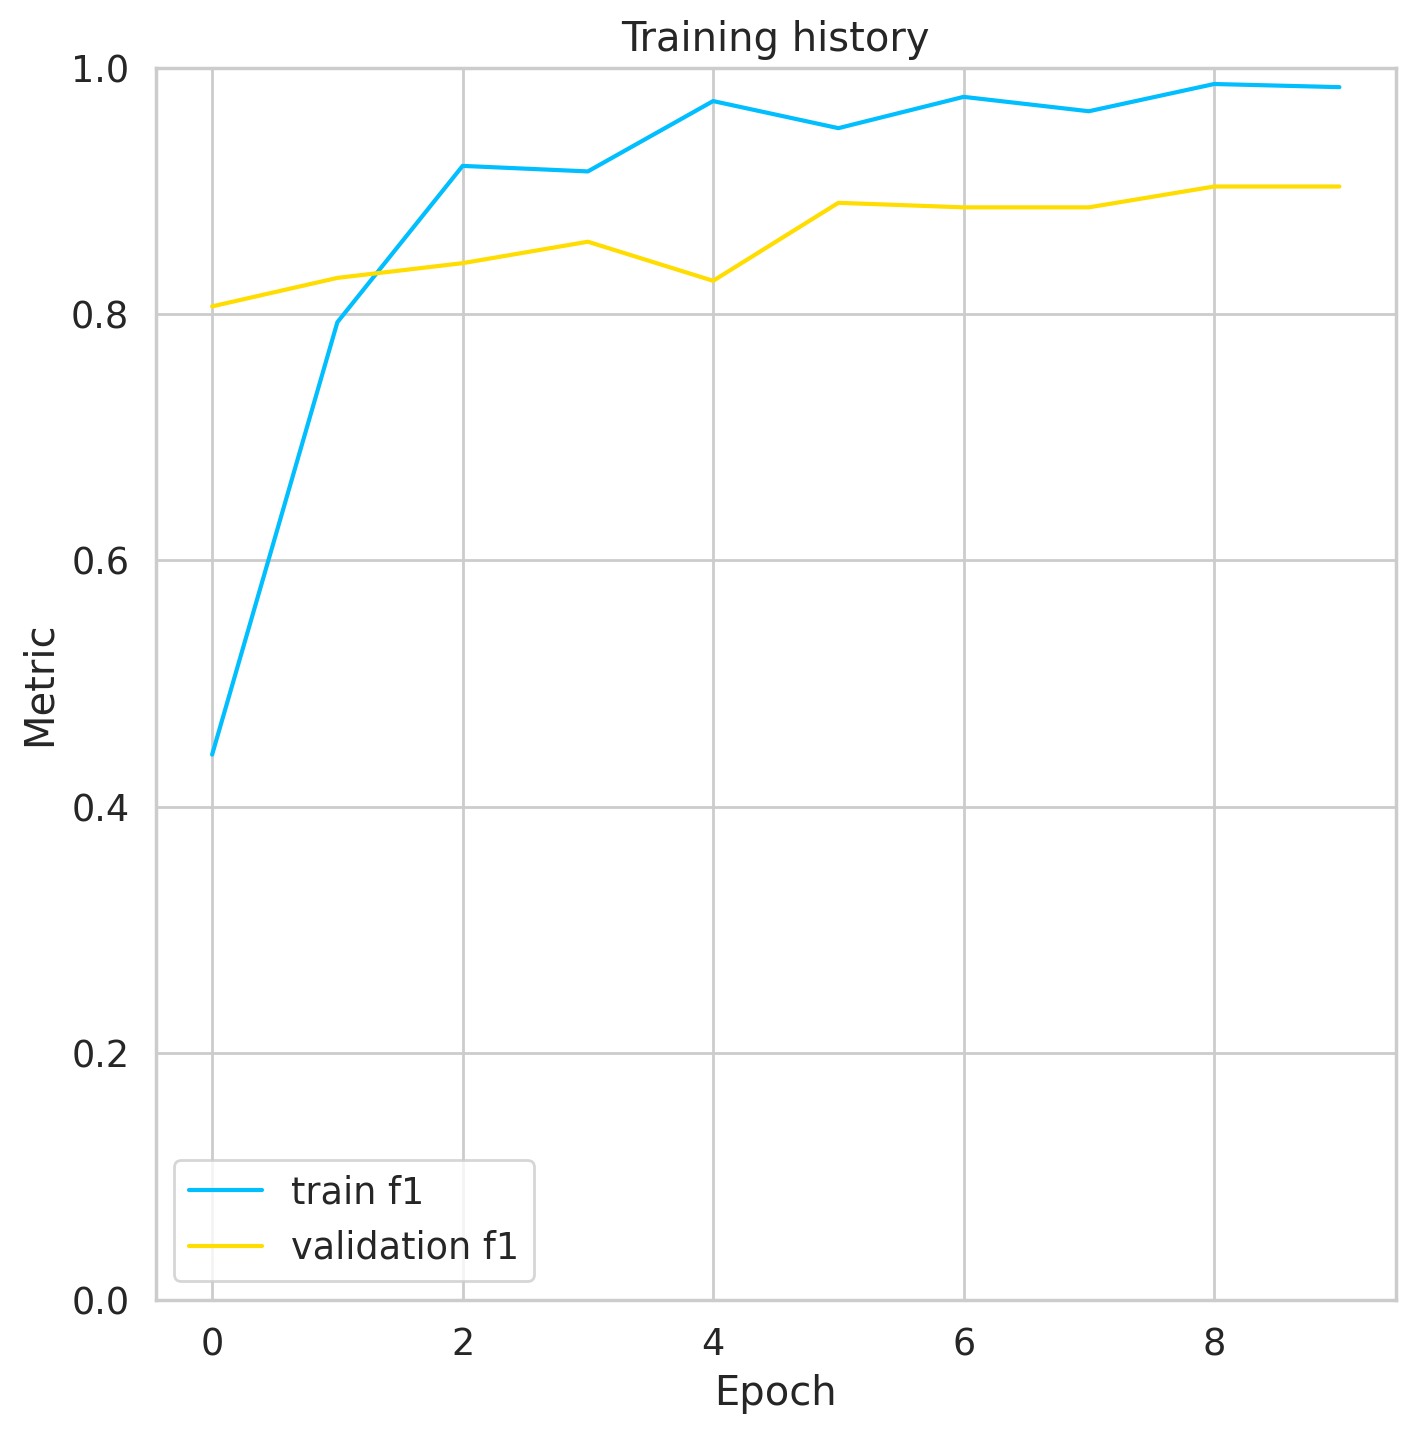

In [45]:
plt.plot(train_metrics, label='train f1')
plt.plot(test_metrics ,label='validation f1')

plt.title('Training history')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evalutaion Framework

In [120]:
def get_predictions(model, data_loader):

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  model.eval()
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      ).flatten()

      probs = torch.sigmoid(outputs)
      preds = torch.round(probs)


      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()

  return review_texts, predictions, prediction_probs

In [127]:
raw_sentences = ["What was the sales for brand Hurricane in India?",
                 "How did the sales for brand X varied over last one year?",
                 "Explain how has the impact on water shortage on the production of beer in India?",
                 "How is the performance of Classic lager segment in LP TY compared to LP YA?",
                 "Detail the reasons for drop in sales for brand Corona in the west?",
                 "How did the sales evolved for brand Jupiter over the period of last 6 months?"]

In [128]:
eval_dataset = QuestionClassficationDataset(
  question=raw_sentences,
  targets=None,
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [129]:
eval_dataloader = DataLoader(
  eval_dataset,
  batch_size=1,
  shuffle=False
)

In [130]:
review_texts, predictions, prediction_probs = get_predictions(bert_base_classifier , eval_dataloader)

In [131]:
predictions

tensor([0., 0., 1., 1., 1., 0.])

In [132]:
prediction_probs

tensor([0.0029, 0.4731, 0.9992, 0.9991, 0.9991, 0.4098])

1. Application of Focal loss for unbalanced data
2. application of weights in loss functions
3. A bit more conservative model to tackle overfitting
4. Assure the data to be hetergenous

# References:
https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=EgR6MuNS8jr_
https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
https://github.com/yesdeepakmittal/Sentiment-Classification-using-BERT/blob/main/Sentiment_classification_BERT.ipynb
https://mccormickml.com/2019/07/22/BERT-fine-tuning/
https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=MPgpITmdwvX0
